# Die Daten werden preprocessed

## Die Daten werden gereinigt und balanciert

Mit Datenreinigung wird gemeint, dass Falscheintragungen korrigiert werden.
Die Spaltennamen werden unbenannt.

Die Daten werden hier nach Alter und Geschlacht balanciert. 
Unbalancierte Daten führe häufig zum bias und kann die Accuracy beeinträchtigen.



In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import numpy as np
import h5py
import os
import json
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import missingno as mno
import seaborn as sns
from sklearn import linear_model
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

from bayes_opt import BayesianOptimization
from joblib import Parallel, delayed
from sklearn import svm, datasets
from matplotlib.pyplot import figure
from scipy.stats import ttest_ind
import pickle

fig_with = 10
fig_height = 8
seed = 7

In [2]:
def binary_encode_single_col(dataframe, colname, drop_multi_category =1):
    """cast a string into a binary int variable
    
    Arguments:
        dataframe: DataFrame to change
        colname:   String Column that has to change
        
    Return:
        the changed DataFrame
    
    """
    temp_df = dataframe.copy(deep=True)
    unique_names = temp_df.loc[:,colname].unique()
    is_binary_index = 0
    mapper = {}
    
    for index, name in enumerate(unique_names):
        if type(name)== str:
            if "nein" in name.lower() or "no" in  name.lower():
                mapper[name] = 0
            elif "ja" in name.lower() or "yes" in  name.lower():
                mapper[name] = 1
            else:
                mapper[name] = int(index) 
            is_binary_index+=1

        elif  math.isnan(name):
            mapper[name] = name

    if is_binary_index==2:
        temp_df[colname] = temp_df[colname].replace(mapper)
        return temp_df,mapper,""
    elif is_binary_index >2  or unique_names.dtype.name:
        if drop_multi_category:
            temp_df = temp_df.drop([colname], axis=1)
            return temp_df,  {} , colname
        else:
            temp_df = pd.get_dummies(temp_df, columns=[colname])

            return temp_df, {}, ""
    
    else:
        return temp_df, {} ,""

In [3]:
def list_minus_list(list1, list2):
    return [c for c in list1 if c not in list2]

In [4]:
def append_string_length(text,lenght = 40, char=" "):
    """the string lenght get appended to have the given length"""

    diff = lenght - len(text)
    for u in range(diff):
        text += char
    return text

In [5]:
def mu_char(char, n):

    text = ""
    for i in range(n):
        text += char
    return text

In [6]:
def impute_random(dataframe, missing_columns):
    """crete random values in the given dataframe"""
    #random imputation
    for feature in missing_columns:
        dataframe[feature + '_imp'] = dataframe[feature]
        dataframe = random_imputation(dataframe, feature)
    return dataframe

In [7]:
def get_sampe(df,size, start, end, sex):
    
    import random
    
    sample_list= (df["sex"] == sex) & (df["age_y"] >= start) & (df["age_y"] < end)
    indizes = [index for index,r in enumerate(sample_list) if r == True]

    random_index = sample_list[random.sample(indizes, k=size)]
    random_index = random_index.sort_index()
    series = []
    for i in range(0,df.shape[0]):

        if i in random_index:
            series.append(True) 
        else:
            series.append(False) 

    return pd.Series(series)

Die Spaltenauswahl und unbenennung.

In [8]:
rev_dict = {'age_y': 'Age',
 's_BMI': 'BMI',
 'pmtail_a': 'Waist [cm]',
 'pmhuft_a': 'Hips [cm]',
 'TL_DM': 'Diabetes mellitus',
 's_hxalk_a': 'Alcohol',
 'hxchol_ps': 'Hypercholesterolemia',
 'TL_VHF_corrected': 'Atrial fibrillations',
 'TL_HTN': 'Hyptertension',
 'TL_pAVK_corrected': 'Peripheral artery disease',
 'TL_Angi_pectoris': 'Angina pectoris',
 'TL_Herzinfarkt': 'Myocardial infarction',
 'depent_before_stroke': 'Dependent before stroke',
 's_aktiv_1y': 'Physical activity level',
 'pmrrsr_1a': 'Systolic bloodpressure',
 'pmrrdr_1a': 'Diastolic bloodpressure',
 'pmglu': 'Glucose',
 'pmhba': 'HbA1c',
 'pmchol': 'Cholesterol',
 'pmhdl': 'HDL',
 'pmldl': 'LDL',
 'pmtg': 'Triglycerides',
 'pmkrea': 'Creatinine',
 'eGFR': 'eGFR',
 'hsCRP': 'hsCRP',
 'pmleuko': 'Leukocytes',
 'ReVas1': 'Revascularisation',
 'Lyse': 'Thrombolysis',
 'DWI_V': 'Acute infarct V [ml] (DWI)',
 'FLAIR_V': 'Acute infarct V [ml] (FLAIR)',
 'chronic_V': 'Chronic infarct V [ml]',
 'acute_infarct': 'Acute infarct',
 'chronic_infarct': 'Chronic infarct',
 'uni_bilateral': 'Uni-/Bilateral infarct',
 'WahlundScore': 'Wahlund Score',
 'scnihg_a': 'NIHSS',
 'sex': 'Sex',
 'infarct_side_1.0': 'Side of infarction: left',
 'infarct_side_2.0': 'Side of infarction: right',
 'infarct_side_3.0': 'Side of infarction: both',
 'infarct_pattern_1.0': 'Infarct pattern: territorial with subcortical and cortical',
 'infarct_pattern_2.0': 'Infarct pattern: subcortical',
 'infarct_pattern_3.0': 'Infarct pattern: scattered',
 'infarct_pattern_4.0': 'Infarct pattern: lacunar',
 'infarct_pattern_5.0': 'Infarct pattern: infratentorial',
 'infarct_pattern_9.0': 'Infarct pattern: watershed',
 'infarct_origin_1.0': 'Infarct origin: MCA',
 'infarct_origin_2.0': 'Infarct origin: ACA',
 'infarct_origin_3.0': 'Infarct origin: PCA',
 'infarct_origin_4.0': 'Infarct origin: AchA',
 'infarct_origin_5.0': 'Infarct origin: infratentorial',
 'infarct_origin_6.0': 'Infarct origin: Thalamus',
 'infarct_origin_9.0': 'Infarct origin: multiple areas',
 'supra_infratentorial_1.0': 'Supratentorial infarct',
 'supra_infratentorial_2.0': 'Infratentorial infarct',
 'supra_infratentorial_3.0': 'Supra- and infratentorial infarct',
 's_kltoas_TL2_0.0': 'TOAST: large-artery atherosclerosis',
 's_kltoas_TL2_1.0': 'TOAST: cardioembolism',
 's_kltoas_TL2_2.0': 'TOAST: small-vessel occlusion',
 's_kltoas_TL2_3.0': 'TOAST: other determined etiology',
 's_kltoas_TL2_4.0': 'TOAST: undetermined etiology',
 'hxsmok_a_0.0': 'Non-smoker',
 'hxsmok_a_1.0': 'Active smoker',
 'hxsmok_a_2.0': 'Former smoker'}

In [9]:
in_dict = {
 'Age': 'age_y',
 'BMI': 's_BMI',
 'Waist [cm]': 'pmtail_a',
 'Hips [cm]': 'pmhuft_a',
 'Diabetes mellitus': 'TL_DM',
 'Alcohol': 's_hxalk_a',
 'Hypercholesterolemia': 'hxchol_ps',
 'Atrial fibrillations': 'TL_VHF_corrected',
 'Hyptertension': 'TL_HTN',
 'Peripheral artery disease': 'TL_pAVK_corrected',
 'Angina pectoris': 'TL_Angi_pectoris',
 'Myocardial infarction': 'TL_Herzinfarkt',
 'Dependent before stroke': 'depent_before_stroke',
 'Physical activity level': 's_aktiv_1y',
 'Systolic bloodpressure': 'pmrrsr_1a',
 'Diastolic bloodpressure': 'pmrrdr_1a',
 'Glucose': 'pmglu',
 'HbA1c': 'pmhba',
 'Cholesterol': 'pmchol',
 'HDL': 'pmhdl',
 'LDL': 'pmldl',
 'Triglycerides': 'pmtg',
 'Creatinine': 'pmkrea',
 'eGFR': 'eGFR',
 'hsCRP': 'hsCRP',
 'Leukocytes': 'pmleuko',
 'Revascularisation': 'ReVas1',
 'Thrombolysis': 'Lyse',
 'Acute infarct V [ml] (DWI)': 'DWI_V',
 'Acute infarct V [ml] (FLAIR)': 'FLAIR_V',
 'Chronic infarct V [ml]': 'chronic_V',
 'Acute infarct': 'acute_infarct',
 'Chronic infarct': 'chronic_infarct',
 'Uni-/Bilateral infarct': 'uni_bilateral',
 'Wahlund Score': 'WahlundScore',
 'NIHSS': 'scnihg_a',
 'Sex': 'sex',
 "Smoking":"hxsmok_a",
 'Education [years]': 'i_bi_y', 
 'TOAST':'s_kltoas_TL2',
 'Infarct Side':'infarct_side',
 'Infarct Pattern':'infarct_pattern',
 'Infarct Origin':'infarct_origin',
 'Supra-/Infratentorial':'supra_infratentorial',
}


out_dict = {
            "Barthel Index":"scbig_a",        #
            "Barthel Index after 1 year":"scbigb_1y",        #
            "mRS":"mRS_a_neu",                # 
            "mRS after 1 year":"scrank_1y",                # 
            "MMSE":"scmmg",                   #
            "TICS-M":"TICS_sum_1", #
            "CES-D":"CESD_min_1",  # 
            "Survival ≤ 3 years"      :"surv_y_all_3",
            "Survival ≤ 1 year"      :"surv_y_all_1"
           }
id_col = {"kskopseu":"ID"}

In [10]:
model_names = {
            "GradientBoostingClassifier":"GB",
            "LinearSVC":"SVC-lin",                      #schon binär
            "SVC":"SVC-rbf",                  #2 soll eins werden
           }

Die komplette Daten werden geladen und ID Spaltenname wird so unbenannt dass es erkenntlich ist.

In [11]:
#education_columns = ["ID","qasbi_ab", "i_bi_y", "s_bild"]
education_columns = ["ID","i_bi_y"]
new_var_columns = ["ID","scbigb_1y","scrank_1y"]
perDaten_path = '/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/'
datasets_path    = perDaten_path + "datasets/"
education_path = datasets_path+'PROSCIS_workingdata3y_02-08-2021-LF.sav'
education_df = pd.read_spss(education_path)
education_df = education_df.rename(columns={"kskopseu":"ID"})
education_df = education_df.loc[:,education_columns]
new_var_path = perDaten_path + "datasets/PROSCIS_workingdata3y_8-09-2021_Lea.sav"
new_var_df   = pd.read_spss(new_var_path)
new_var_df   = new_var_df.rename(columns={"kskopseu":"ID"})
new_var_df   = new_var_df.loc[:,new_var_columns]
#education_df = education_df.astype({'qasbi_ab': 'category'})


#education_df.info()

In [12]:
clinical_path = "/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/PROSCIS_clinical_data_complete.xlsx"
proscis_comp = pd.read_excel(clinical_path)
proscis_comp = proscis_comp.rename(columns={"kskopseu":"ID"})
proscis_comp = proscis_comp.join(education_df.set_index('ID'), on='ID')
proscis_comp = proscis_comp.join(new_var_df.set_index('ID'), on='ID')
proscis_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Columns: 135 entries, Unnamed: 0 to scrank_1y
dtypes: datetime64[ns](16), float64(54), int64(12), object(53)
memory usage: 661.4+ KB


In [13]:
#save paths
perDaten_path = '/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/'
balanced_path = perDaten_path+ 'datasets/PORSCIS_balanced_dataset.xlsx'
u_balanced_path = perDaten_path+ 'datasets/PORSCIS_un_balanced_dataset.xlsx'

In [14]:
# get the ids 
masterpath = "/home/temuuleu/PROSCIS/CSB/S-PROSCIS_MRT/persDaten/MASTERFILE_MR_DATA_Kufner_LF.xlsx"
MASTERFILE = pd.read_excel(masterpath)
MASTERFILE_renamed = MASTERFILE.rename(columns={"kskopseu":"ID"})
MF_df = MASTERFILE_renamed[["ID",'Manual DL complete (y/n)','Automatic DL successful (y/n)']]
ID = MF_df.loc[(MF_df['Manual DL complete (y/n)'] == 'y') | (MF_df['Automatic DL successful (y/n)'] == 'y'), "ID"]

In [15]:
names = {}

df_work = proscis_comp[proscis_comp['ID'].isin(list(ID))]
df_work['sex'].replace("male",0, inplace = True)
df_work['sex'].replace("female",1, inplace = True)
df_work = df_work.astype({'sex': 'category'})
df_work['scmmg'].replace(['missing'],np.NAN, inplace = True)
df_work['hxsmok_a'].replace([' nein'],0, inplace = True)
df_work['hxsmok_a'].replace([' ja'],1, inplace = True)
df_work['hxsmok_a'].replace(['nein, aber früher regelmäßig'],2, inplace = True)
df_work['hxsmok_a'].replace([9],np.NAN, inplace = True)
df_work = df_work.astype({'hxsmok_a': 'category'})

df_work['TL_DM'].replace(['nein'],0, inplace = True)
df_work['TL_DM'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'TL_DM': 'category'})

df_work['s_hxalk_a'].replace(['nein'],0, inplace = True)
df_work['s_hxalk_a'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'s_hxalk_a': 'category'})

df_work['hxchol_ps'].replace(['nein'],0, inplace = True)
df_work['hxchol_ps'].replace(['ja'],1, inplace = True)
df_work['hxchol_ps'].replace(['keine Angabe/nicht dokumentiert'],np.NAN, inplace = True)
df_work['hxchol_ps'].replace([' unsicher/weiß nicht'],np.NAN, inplace = True)
df_work['hxchol_ps'].replace(['unsicher/weiß nicht'],np.NAN, inplace = True)
df_work = df_work.astype({'hxchol_ps': 'category'})

df_work['TL_VHF_corrected'].replace(['nein'],0, inplace = True)
df_work['TL_VHF_corrected'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'TL_VHF_corrected': 'category'})

df_work['TL_HTN'].replace(['nein'],0, inplace = True)
df_work['TL_HTN'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'TL_HTN': 'category'})

df_work['TL_pAVK_corrected'].replace(['nein'],0, inplace = True)
df_work['TL_pAVK_corrected'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'TL_pAVK_corrected': 'category'})

df_work['TL_Angi_pectoris'].replace(['nein'],0, inplace = True)
df_work['TL_Angi_pectoris'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'TL_Angi_pectoris': 'category'})

df_work['TL_Herzinfarkt'].replace(['nein'],0, inplace = True)
df_work['TL_Herzinfarkt'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'TL_Herzinfarkt': 'category'})

df_work['depent_before_stroke'].replace(['nein'],0, inplace = True)
df_work['depent_before_stroke'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'depent_before_stroke': 'category'})

df_work['s_aktiv_1y'].replace(['nicht bis gering'],0, inplace = True)
df_work['s_aktiv_1y'].replace(['stark bis sehr stark'],1, inplace = True)
df_work = df_work.astype({'s_aktiv_1y': 'category'})

df_work['ReVas1'].replace(['nein'],0, inplace = True)
df_work['ReVas1'].replace(['ja'],1, inplace = True)
df_work = df_work.astype({'ReVas1': 'category'})

df_work['Lyse'].replace(['no'],0, inplace = True)
df_work['Lyse'].replace(['yes'],1, inplace = True)
df_work = df_work.astype({'Lyse': 'category'})

df_work = df_work.rename(columns={"DWILesionvolumemL":"DWI_V"})
df_work = df_work.rename(columns={"FLAIRLesionvolumemL":"FLAIR_V"})
df_work = df_work.rename(columns={"ChronicinfarctionvolumemL":"chronic_V"})

df_work = df_work.rename(columns={"AcuteinfarctDWI1yes2no":"acute_infarct"})

df_work = df_work[df_work["acute_infarct"] == 1]
df_work = df_work.rename(columns={"age":"age_y"})

#die 2 entfernen
#df_work['acute_infarct'].replace(0,1, inplace = True)
#df_work['acute_infarct'].replace(2,0, inplace = True)

df_work = df_work.astype({'acute_infarct': 'category'})

df_work = df_work.rename(columns={"ChronicInfarction1yes0no":"chronic_infarct"})
df_work = df_work.astype({'chronic_infarct': 'category'})

df_work = df_work.rename(columns={"Sideofacuteinfarction1Left2Right3both":"infarct_side"})
df_work = df_work.astype({'infarct_side': 'category'})

df_work = df_work.rename(columns={"InfarctPattern1territorialwithsubcorticalandcortical2subcortical":"infarct_pattern"})
df_work = df_work.astype({'infarct_pattern': 'category'})

df_work = df_work.rename(columns={"@0keinNachweis1MCA2ACA3PCA4AchA5infratentoriellAICASUCAPONSPICAM":"infarct_origin"})
df_work = df_work.astype({'infarct_origin': 'category'})

#.58 entfernen
df_work = df_work.rename(columns={"Unilateral1orBilateral2":"uni_bilateral"})
df_work = df_work.astype({'uni_bilateral': 'category'})
df_work['uni_bilateral'].replace(0.58,1, inplace = True)
df_work['uni_bilateral'].replace(2,0, inplace = True)

df_work = df_work.rename(columns={"Supravs.Infratentorial1Supra2Infra3both":"supra_infratentorial"})
df_work['supra_infratentorial'].replace([5],2, inplace = True)
df_work = df_work.astype({'supra_infratentorial': 'category'})

df_work['depent_before_stroke'].replace(['no'],0, inplace = True)
df_work['depent_before_stroke'].replace(['yes'],1, inplace = True)
df_work = df_work.astype({'depent_before_stroke': 'category'})

#
df_work['s_kltoas_TL2'].replace(['kardioembolisch'],0, inplace = True)
df_work['s_kltoas_TL2'].replace(['makroangiopathisch'],1, inplace = True)
df_work['s_kltoas_TL2'].replace(['ungeklärte Ätiologie'],2, inplace = True)
df_work['s_kltoas_TL2'].replace(['andere Ursache'],3, inplace = True)
df_work['s_kltoas_TL2'].replace(['mirkoangiopathisch'],4, inplace = True)

df_work = df_work.astype({'s_kltoas_TL2': 'category'})
# find strings containing multiple entries in infarct origin and replace them with category 10

str_list=['1;2', '1; 6', '1; 5 ','5 ; 6','1 ; 5 ',
       '1 ; 3', '3;4', '3 ; 5 ', '1 ; 3 ', '1 ; 3; 5', '1; 3',
       '9 ; 3 ; 5 ', '3; 6', '3; 5', '1; 2', '4; 3', '1;3', '3;5', '1; 5',
       '1 ; 2 ', '1 ; 4', '1 ; 2; 3 ', '1; 6 ; 5', '6 ; 5', '1 , 6',
       '1 , 3 , 6 ', '1;3; 5', '4; 5', ' ', '1;5','1; 3; 5','1; 10', '1;2; 10', '1; 2; 4; 6','1; 3; 10', '1; 5; 10', '1 ; 3; 10 ', '1; 2; 3; 10',
       '1; 2; 3; 5; 10', '1 ; 2 ; 10', '1 ; 3 ; 10', '1; 3; 5; 10',
       '6; 5','1; 2 , 3 , 6; 10', '3; 5; 6', '1; 4', '1; 2; 10',
       '1 ; 2; 3 ; 5', '1 ; 5',
         '3 ; 5',
         '9 ; 3 ; 5',
         '1 ; 2',
         '1 ; 2; 3',
         '1 , 3 , 6',
         '1 ; 3 ; 5',
         '3 ;6']

for n in str_list:
    df_work["infarct_origin"] = df_work["infarct_origin"].replace({n:9})
df_work["infarct_origin"] = df_work["infarct_origin"].dropna().astype({'infarct_origin': 'int'})

#qasbi_ab = {}

#for z, val in enumerate(list(df_work['qasbi_ab'].unique())):
#    qasbi_ab[z] = val
#    df_work['qasbi_ab'].replace([val],z, inplace = True)
#   
#names["qasbi_ab"] = qasbi_ab

/opt/anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
#s_bild = {}
#
#df_work['s_bild'].replace(['?'],np.NaN, inplace = True)
#df_work['s_bild'].replace(['ohne Abschluss'],0, inplace = True)
#df_work['s_bild'].replace(['bis 10. Klasse'],1, inplace = True)
#df_work['s_bild'].replace(['höher'],2, inplace = True)

#s_bild[0] = 'ohne Abschluss'
#s_bild[1] = 'bis 10. Klasse'
#s_bild[2] = 'höher'

#names["s_bild"] = s_bild

In [17]:
#print(education_columns[1])
#df_work[education_columns[1]].hist()

# Compute the correlation matrix
corr = proscis_master_numerical.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [18]:
#corr = df_work[["CESD_min_1","TICS_sum_1","scmmg","surv_y_all","scbig_a","mRS_a_neu","pmglu"]].corr()

In [19]:
df_work = df_work.astype({'infarct_origin': 'category'})
df_work.shape

(415, 135)

In [20]:
#result.to_csv("preprocessed_clinical.csv")
#result.to_excel("preprocessed_clinical.xlsx")

In [21]:
full_count = df_work.shape[0]
women_count = np.sum(df_work["sex"] == 1)
men_count = np.sum(df_work["sex"] == 0)
print("women and men",full_count)
print("women        ",women_count)
print("men          ",men_count)

women and men 415
women         153
men           262


In [22]:
input_X = df_work.loc[:,["ID","sex","age_y"]]

In [23]:
input_X.columns

Index(['ID', 'sex', 'age_y'], dtype='object')

In [24]:
#x_Train_Test, x_Validation, y_Train_Test, y_Validation = train_test_split(input_X, output_Y, test_size = 0.15, random_state = 0)
#x_Train, x_Test, y_Train, y_Test = train_test_split(x_Train_Test, y_Train_Test, test_size = 0.15, random_state = 0)

In [25]:
median_age_men = input_X[(input_X["sex"] == 0)]["age_y"].median()
median_age_women = input_X[(input_X["sex"] == 1)]["age_y"].median()
mean_age_men = input_X[(input_X["sex"] == 0)]["age_y"].mean()
mean_age_women = input_X[(input_X["sex"] == 1)]["age_y"].mean()

print("mean age men",np.round(mean_age_men))
print("mean age women",np.round(mean_age_women))

print("median age men",median_age_men)
print("median age women",median_age_women)

mean age men 63.0
mean age women 69.0
median age men 64.0
median age women 73.0


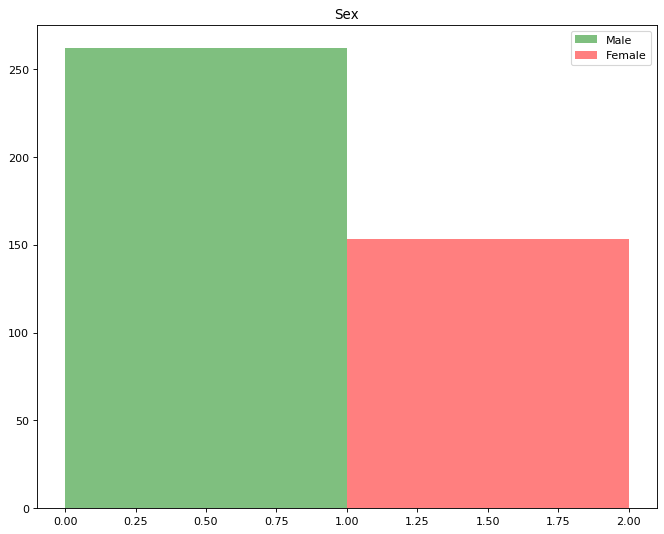

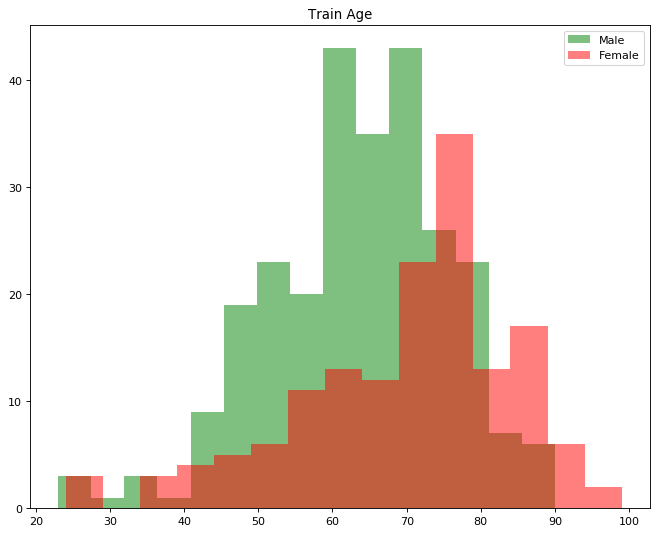

In [26]:
figure(num=None, figsize=(fig_with, fig_height), dpi=80, facecolor='w', edgecolor='k')
plt.title('Sex')
plt.hist(input_X.loc[input_X["sex"] == 0, "sex"], alpha=0.5,facecolor='green' , range=(0,2), bins=2, label = "Male")
plt.hist(input_X.loc[input_X["sex"] == 1, "sex"], alpha=0.5,facecolor='red' ,range=(0,2), bins=2, label = "Female")
plt.legend()
plt.show()

figure(num=None, figsize=(fig_with, fig_height), dpi=80, facecolor='w', edgecolor='k')
plt.title('Train Age')
plt.hist(input_X.loc[input_X["sex"] == 0, "age_y"], alpha=0.5,facecolor='green' , bins=15, label = "Male")
plt.hist(input_X.loc[input_X["sex"] == 1, "age_y"], alpha=0.5,facecolor='red' , bins=15, label = "Female")
plt.legend()
plt.show()

In [27]:
print("men count between 40 and 60: ",sum((input_X["sex"] == 0) & (input_X["age_y"] >= 40) & (input_X["age_y"] < 60)))

men count between 40 and 60:  79


In [28]:
print("men count between 60 and 72: ",sum((input_X["sex"] == 0) & (input_X["age_y"] >= 60) & (input_X["age_y"] < 72)))

men count between 60 and 72:  107


In [29]:
print("men count outside 60 and 72: ",sum((input_X["sex"] == 0) & ((input_X["age_y"] < 40) | (input_X["age_y"] >= 72))))

men count outside 60 and 72:  76


In [30]:
print("wommen count outside over 80: ",sum((input_X["sex"] == 1) & (input_X["age_y"] > 80)))

wommen count outside over 80:  34


In [31]:
print("women count between 70 and 80: ",sum((input_X["sex"] == 1) & ((input_X["age_y"] < 80) & (input_X["age_y"] >= 70))))

women count between 70 and 80:  59


In [32]:
print("women count between 70 and 80: ",sum((input_X["sex"] == 1) & ((input_X["age_y"] < 70) & (input_X["age_y"] >= 54))))

women count between 70 and 80:  37


In [33]:
print("women count between 40 and 54: ",sum((input_X["sex"] == 1) & ((input_X["age_y"] < 54) & (input_X["age_y"] >= 40))))

women count between 40 and 54:  14


In [34]:
print("wommen count outside over 40: ",sum((input_X["sex"] == 1) & (input_X["age_y"] < 40)))

wommen count outside over 40:  7


In [35]:
 42+12+3

57

In [36]:
while(1):
    m_61_72 = list(get_sampe(input_X,size = 57, start = 60, end = 72, sex = 0))
    m_41_60 = list(get_sampe(input_X,size = 29, start = 41, end = 60, sex = 0))
    m_out = list((input_X["age_y"] > 72) | (input_X["age_y"] <= 40)) & (input_X["sex"] == 0) 

    input_X_1_m =     input_X[m_41_60]
    input_X_2_m =     input_X[m_61_72]
    input_X_3_m =     input_X[m_out]

    m_df = pd.concat([input_X_1_m,input_X_2_m,input_X_3_m])
    
    w_80 = list(get_sampe(input_X,size = 34, start = 80, end = 100, sex = 1))
    w_70_80 = list(get_sampe(input_X,size = 59, start = 70, end = 80, sex = 1))
    w_54_70 = list(get_sampe(input_X,size = 37, start = 54, end = 70, sex = 1))
    w_40_54 = list(get_sampe(input_X,size = 14, start = 40, end = 54, sex = 1))
    w_40 = list((input_X["sex"] == 1) & (input_X["age_y"] < 40))


    input_X_1_w =     input_X[w_40]
    input_X_2_w =     input_X[w_40_54]
    input_X_3_w =     input_X[w_54_70]
    input_X_4_w =     input_X[w_70_80]
    input_X_5_w =     input_X[w_80]


    w_df = pd.concat([input_X_1_w,input_X_2_w,input_X_3_w,input_X_4_w,input_X_5_w])
    
    f_balanced = w_df["age_y"].dropna().to_numpy()
    m_balanced = m_df["age_y"].dropna().to_numpy()
    
    all_balanced = pd.concat([m_df,w_df])
    
    print("Balanced age:  p-Value:", round(ttest_ind(f_balanced, m_balanced)[1], 2))
    
    if round(ttest_ind(f_balanced, m_balanced)[1], 2) == 0.1:
        
        print("Balanced age:  p-Value:", round(ttest_ind(f_balanced, m_balanced)[1], 2))
        print("Dataset size : ", all_balanced.shape[0])
        Train_median_age_F   = np.median(all_balanced["age_y"].loc[all_balanced["sex"]==1])
        Train_median_age_M   = np.median(all_balanced["age_y"].loc[all_balanced["sex"]==0])
        Train_mean_age_F   = np.mean( all_balanced["age_y"].loc[all_balanced["sex"]==1])
        Train_mean_age_M   = np.mean( all_balanced["age_y"].loc[all_balanced["sex"]==0])

        print("Train Median Age female ",Train_median_age_F)
        print("Train Median Age male ",Train_median_age_M)

        print("Train Mean Age female ",round(Train_mean_age_F))
        print("Train Mean Age male ",round(Train_mean_age_M))
        break

Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.08
Balanced age:  p-Value: 0.05


/opt/anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Balanced age:  p-Value: 0.09
Balanced age:  p-Value: 0.07
Balanced age:  p-Value: 0.04
Balanced age:  p-Value: 0.06
Balanced age:  p-Value: 0.04
Balanced age:  p-Value: 0.04
Balanced age:  p-Value: 0.07
Balanced age:  p-Value: 0.03
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.06
Balanced age:  p-Value: 0.07
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.07
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.06
Balanced age:  p-Value: 0.04
Balanced age:  p-Value: 0.04
Balanced age:  p-Value: 0.03
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.06
Balanced age:  p-Value: 0.04
Balanced age:  p-Value: 0.05
Balanced age:  p-Value: 0.1
Balanced age:  p-Value: 0.1
Dataset size :  307
Train Median Age female  73.0
Train Median Age male  70.0
Train Mean Age female  69
Train Mean Age male  67


Train count male 156
Train count female 151


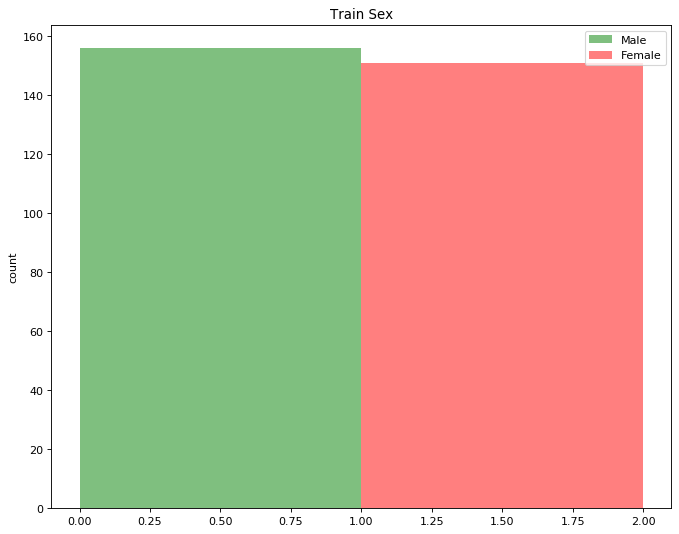

Train Median Age female  73.0
Train Median Age male  70.0


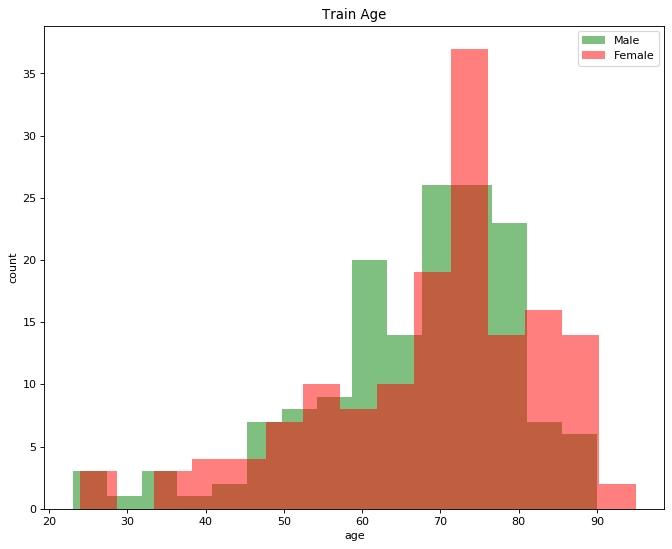

In [37]:
x_Train = all_balanced

print("Train count male",np.sum(x_Train["sex"] == 0))
print("Train count female",np.sum(x_Train["sex"] == 1))

figure(num=None, figsize=(fig_with, fig_height), dpi=80, facecolor='w', edgecolor='k')
plt.title('Train Sex')
plt.hist(x_Train.loc[x_Train["sex"] == 0, "sex"], alpha=0.5,facecolor='green' , range=(0,2), bins=2, label = "Male")
plt.hist(x_Train.loc[x_Train["sex"] == 1, "sex"], alpha=0.5,facecolor='red' ,range=(0,2), bins=2, label = "Female")
plt.xlabel('')
plt.ylabel('count') 
plt.legend()
plt.show()
Train_median_age_F   = np.median(x_Train["age_y"].loc[x_Train["sex"]==1])
Train_median_age_M   = np.median(x_Train["age_y"].loc[x_Train["sex"]==0])

print("Train Median Age female ",Train_median_age_F)
print("Train Median Age male ",Train_median_age_M)
figure(num=None, figsize=(fig_with, fig_height), dpi=80, facecolor='w', edgecolor='k')
plt.title('Train Age')
plt.hist(x_Train.loc[x_Train["sex"] == 0, "age_y"], alpha=0.5,facecolor='green' , bins=15, label = "Male")
plt.hist(x_Train.loc[x_Train["sex"] == 1, "age_y"], alpha=0.5,facecolor='red' , bins=15, label = "Female")
plt.xlabel('age')
plt.ylabel('count') 
plt.legend()
plt.show()


In [38]:
proscis_master_all =  df_work.copy()

output_list = []
proscis_master_all['scbig_a']    = proscis_master_all["scbig_a"][proscis_master_all["scbig_a"].notnull()]  >= 61
proscis_master_all["scbig_a"]    = proscis_master_all["scbig_a"].round()
proscis_master_all["scbig_a"]    = proscis_master_all["scbig_a"].replace([True],1).copy()
proscis_master_all["scbig_a"]    = proscis_master_all["scbig_a"].replace([False],0).copy()

proscis_master_all['scbigb_1y']    = proscis_master_all["scbigb_1y"][proscis_master_all["scbigb_1y"].notnull()]  >= 61
proscis_master_all["scbigb_1y"]    = proscis_master_all["scbigb_1y"].round()
proscis_master_all["scbigb_1y"]    = proscis_master_all["scbigb_1y"].replace([True],1).copy()
proscis_master_all["scbigb_1y"]    = proscis_master_all["scbigb_1y"].replace([False],0).copy()

output_list.append("scbig_a")
proscis_master_all["mRS_a_neu"]    = proscis_master_all["mRS_a_neu"][proscis_master_all["mRS_a_neu"].notnull()]  <= 2
proscis_master_all["mRS_a_neu"]    = proscis_master_all["mRS_a_neu"].replace([True],1).copy()
proscis_master_all["mRS_a_neu"]    = proscis_master_all["mRS_a_neu"].replace([False],0).copy()
#proscis_master_all["mRS_a_neu"].hist()
#plt.show()
output_list.append("mRS_a_neu")

proscis_master_all["scrank_1y"]    = proscis_master_all["scrank_1y"][proscis_master_all["scrank_1y"].notnull()]  <= 2
proscis_master_all["scrank_1y"]    = proscis_master_all["scrank_1y"].replace([True],1).copy()
proscis_master_all["scrank_1y"]    = proscis_master_all["scrank_1y"].replace([False],0).copy()

proscis_master_all['scmmg']    = proscis_master_all["scmmg"][proscis_master_all["scmmg"].notnull()]  >= 24
proscis_master_all["scmmg"]    = proscis_master_all["scmmg"].replace([True],1).copy()
proscis_master_all["scmmg"]    = proscis_master_all["scmmg"].replace([False],0).copy()
#proscis_master_all["scmmg"].hist()
#plt.show()
output_list.append("scmmg")

proscis_master_all["CESD_min_1"]    = proscis_master_all["CESD_min_1"][proscis_master_all["CESD_min_1"].notnull()] <= 15
proscis_master_all["CESD_min_1"]    = proscis_master_all["CESD_min_1"].replace([True],1).copy()
proscis_master_all["CESD_min_1"]    = proscis_master_all["CESD_min_1"].replace([False],0).copy()
#proscis_master_all["CESD_min_1"].hist()
#plt.show()
output_list.append("CESD_min_1")

proscis_master_all["TICS_sum_1"]    = proscis_master_all["TICS_sum_1"][proscis_master_all["TICS_sum_1"].notnull()] >= 30
proscis_master_all["TICS_sum_1"]    = proscis_master_all["TICS_sum_1"].replace([True],1).copy()
proscis_master_all["TICS_sum_1"]    = proscis_master_all["TICS_sum_1"].replace([False],0).copy()
#proscis_master_all["TICS_sum_1"].hist()
#plt.show()

output_list.append("TICS_sum_1")

proscis_master_all["surv_y_all_3"]    = proscis_master_all["surv_y_all"][proscis_master_all["surv_y_all"].notnull()] >= 3
proscis_master_all["surv_y_all_3"]    = proscis_master_all["surv_y_all_3"].round()
proscis_master_all["surv_y_all_3"]    = proscis_master_all["surv_y_all_3"].replace([True],1).copy()
proscis_master_all["surv_y_all_3"]    = proscis_master_all["surv_y_all_3"].replace([False],0).copy()
output_list.append("surv_y_all_3")


proscis_master_all["surv_y_all_1"]    = proscis_master_all["surv_y_all"][proscis_master_all["surv_y_all"].notnull()] >= 1
proscis_master_all["surv_y_all_1"]    = proscis_master_all["surv_y_all_1"].round()
proscis_master_all["surv_y_all_1"]    = proscis_master_all["surv_y_all_1"].replace([True],1).copy()
proscis_master_all["surv_y_all_1"]    = proscis_master_all["surv_y_all_1"].replace([False],0).copy()

output_list.append("surv_y_all_1")
output_list.append("sex")

In [39]:
input_columns_binary         = []
input_columns_multiple_cat   = []
input_columns_numerical      = []

input_columns_numerical     += ["sex_index"]
input_columns_numerical     += ["ID"]
#bin_cat_cols 

for col_name in list(proscis_master_all[list(in_dict.values())].columns):
    unique_len = len(proscis_master_all[col_name].dropna().unique())
    
    if col_name not in list(out_dict.values()) and col_name in list(in_dict.values()):
        
        if unique_len == 2:
            #print(col_name)
            #print("bin unique_len:", unique_len)
            input_columns_binary.append(col_name)
        elif unique_len < 10:
            #print(col_name)
            #print("categorical unique_len:", unique_len)
            input_columns_multiple_cat.append(col_name)
        else:
            #print(col_name)
            #print("numerical unique_len:", unique_len)
            input_columns_numerical.append(col_name)
        #print(" ")

In [40]:
epidemiological = [ 
  'sex',
  'age_y',
  's_BMI',
  'pmtail_a',
  'pmhuft_a',
  'i_bi_y',
]

clinical = [ 
 'TL_DM',
 'hxsmok_a',
 's_hxalk_a',
 'hxchol_ps',
 'TL_VHF_corrected',
 'TL_HTN',
 'TL_pAVK_corrected',
 'TL_Angi_pectoris',
 'TL_Herzinfarkt',
 #'s_fam_hist',
 'depent_before_stroke',
 's_aktiv_1y',
 'pmrrsr_1a',
 'pmrrdr_1a']

blood = [
 'pmglu',
 #'qanglu',
 'pmhba',
 'pmchol',
 'pmhdl',
 'pmldl',
 'pmtg',
 'pmkrea',
 'eGFR',
 'hsCRP',
'pmleuko']

MRI = [
 'DWI_V',
 'FLAIR_V',
 'chronic_V',
 'acute_infarct',
 'chronic_infarct',
 'infarct_side',
 'infarct_origin',
 'infarct_pattern',
 'uni_bilateral',
 'supra_infratentorial',
 'WahlundScore']


list_of_types = {}

list_of_types["epidemiological"] = epidemiological+["sex_index","ID"]
list_of_types["clinical"]        = clinical+["sex_index","ID"]
list_of_types["blood"]           = blood+["sex_index","ID"]
list_of_types["MRI"]             = MRI+["sex_index","ID"]
list_of_types["all"]             = list(in_dict.values())+["sex_index","ID"]

In [41]:
proscis_master_all["sex_index"] = proscis_master_all["sex"]

In [42]:
df_balanced = pd.merge(x_Train.loc[:,"ID"],proscis_master_all, how="inner", on="ID")

In [43]:
df_balanced_dataset    = df_balanced[list(out_dict.values()) + list(in_dict.values()) + ['ID','sex_index']]
df_unbalanced_dataset  = proscis_master_all[list(out_dict.values()) + list(in_dict.values()) + ['ID','sex_index']]

In [44]:
proscis_master_all.shape

(415, 138)

In [45]:
df_unbalanced_dataset.shape

(415, 55)

In [46]:
def create_category_map(X_data , limit = 10):
    """creates category map from a DataFrame and lists of columnnumbers
    
    
    input : DataFrame
    return: Dictionary  :  categorymap 
            List        :  column number of category columns
            List        :  column number of numerical columns
    """
    
    category_map = {}
    
    ordinal_features = []
    categorical_features = []

    for i,col_name in enumerate(X_data.columns):
        unique_len = len(X_data[col_name].dropna().unique())
        
        if unique_len == 2 or unique_len < limit:
            print("Categorical: ")
            print(col_name," : ", unique_len)
            
            categorical_features.append(i)
            
            category_map[i] = {}
            category_map[i] = []

            #if np.isnan(list(X_data[col_name].unique())).any():
            #    category_map[i].append(np.nan)

            cat_values = list(X_data[col_name].unique())
            #cat_values.sort()

            for cat_value in cat_values:
                
                category_map[i].append(cat_value)
        else:
            print("Numerical: ")
            print(col_name," : ", unique_len)
            ordinal_features.append(i)
                        
    #ordinal_features          = [x for x in range(len(X_data.columns)) if x not in list(category_map.keys())]
    #categorical_features      = list(category_map.keys())
                        
    return category_map,categorical_features,ordinal_features,list(X_data.columns)

print(list(list_of_types.keys())[0])
df = proscis_master_all.loc[:,list_of_types[list(list_of_types.keys())[0]]]

category_map,categorical_features,ordinal_features, feature_names = create_category_map(df)
#print(df[:5])
#df = X_t.iloc[:4,ordinal_features]
#print("Ordinal:",pd.Series({c: df[c].unique() for c in df}))

epidemiological
Categorical: 
sex  :  2
Numerical: 
age_y  :  63
Numerical: 
s_BMI  :  338
Numerical: 
pmtail_a  :  63
Numerical: 
pmhuft_a  :  55
Numerical: 
i_bi_y  :  29
Categorical: 
sex_index  :  2
Numerical: 
ID  :  415


In [47]:
print(list(df_unbalanced_dataset.columns))

['scbig_a', 'scbigb_1y', 'mRS_a_neu', 'scrank_1y', 'scmmg', 'TICS_sum_1', 'CESD_min_1', 'surv_y_all_3', 'surv_y_all_1', 'age_y', 's_BMI', 'pmtail_a', 'pmhuft_a', 'TL_DM', 's_hxalk_a', 'hxchol_ps', 'TL_VHF_corrected', 'TL_HTN', 'TL_pAVK_corrected', 'TL_Angi_pectoris', 'TL_Herzinfarkt', 'depent_before_stroke', 's_aktiv_1y', 'pmrrsr_1a', 'pmrrdr_1a', 'pmglu', 'pmhba', 'pmchol', 'pmhdl', 'pmldl', 'pmtg', 'pmkrea', 'eGFR', 'hsCRP', 'pmleuko', 'ReVas1', 'Lyse', 'DWI_V', 'FLAIR_V', 'chronic_V', 'acute_infarct', 'chronic_infarct', 'uni_bilateral', 'WahlundScore', 'scnihg_a', 'sex', 'hxsmok_a', 'i_bi_y', 's_kltoas_TL2', 'infarct_side', 'infarct_pattern', 'infarct_origin', 'supra_infratentorial', 'ID', 'sex_index']


In [48]:
in_dict

{'Age': 'age_y',
 'BMI': 's_BMI',
 'Waist [cm]': 'pmtail_a',
 'Hips [cm]': 'pmhuft_a',
 'Diabetes mellitus': 'TL_DM',
 'Alcohol': 's_hxalk_a',
 'Hypercholesterolemia': 'hxchol_ps',
 'Atrial fibrillations': 'TL_VHF_corrected',
 'Hyptertension': 'TL_HTN',
 'Peripheral artery disease': 'TL_pAVK_corrected',
 'Angina pectoris': 'TL_Angi_pectoris',
 'Myocardial infarction': 'TL_Herzinfarkt',
 'Dependent before stroke': 'depent_before_stroke',
 'Physical activity level': 's_aktiv_1y',
 'Systolic bloodpressure': 'pmrrsr_1a',
 'Diastolic bloodpressure': 'pmrrdr_1a',
 'Glucose': 'pmglu',
 'HbA1c': 'pmhba',
 'Cholesterol': 'pmchol',
 'HDL': 'pmhdl',
 'LDL': 'pmldl',
 'Triglycerides': 'pmtg',
 'Creatinine': 'pmkrea',
 'eGFR': 'eGFR',
 'hsCRP': 'hsCRP',
 'Leukocytes': 'pmleuko',
 'Revascularisation': 'ReVas1',
 'Thrombolysis': 'Lyse',
 'Acute infarct V [ml] (DWI)': 'DWI_V',
 'Acute infarct V [ml] (FLAIR)': 'FLAIR_V',
 'Chronic infarct V [ml]': 'chronic_V',
 'Acute infarct': 'acute_infarct',
 'Chron

In [49]:
unbalanced_datasets = {
    "in_dict"                   : in_dict,
    "out_dict"                  : out_dict,
    "labels"                    : list(out_dict.values()),
    "list_of_types"             : list(list_of_types)
}

for label in list(out_dict.values()):

    #unbalanced_datasets["Outputs"][label] = proscis_master_all.loc[:,label]
    indizes = df_unbalanced_dataset.loc[:,label].dropna().index
    #print(proscis_master_all.loc[indizes,:].shape)
    #print(len(indizes))
    X = df_unbalanced_dataset.loc[indizes,:]
    y = df_unbalanced_dataset.loc[indizes,label]
    
    unbalanced_datasets[label] = {}
    unbalanced_datasets[label]["y"] = y
    unbalanced_datasets[label]["Input_datasets"] = {}
    
    for feature_type in list(list_of_types.keys()):
        print(feature_type)
        print("")
        unbalanced_datasets[label]["Input_datasets"][feature_type] = {}
        unbalanced_datasets[label]["Input_datasets"][feature_type]["X"] = X.loc[:,list_of_types[feature_type]]
        category_map,categorical_features,ordinal_features, feature_names = create_category_map(X.loc[:,list_of_types[feature_type]].drop(columns = ["sex_index","ID"]))
        unbalanced_datasets[label]["Input_datasets"][feature_type]["category_map"]         = category_map
        unbalanced_datasets[label]["Input_datasets"][feature_type]["categorical_features"] = categorical_features
        unbalanced_datasets[label]["Input_datasets"][feature_type]["ordinal_features"]     = ordinal_features
        unbalanced_datasets[label]["Input_datasets"][feature_type]["feature_names"]        = feature_names
        print("")
        
with open(datasets_path+'unbalanced_data.pickle', 'wb') as handle:
    pickle.dump(unbalanced_datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

epidemiological

Categorical: 
sex  :  2
Numerical: 
age_y  :  63
Numerical: 
s_BMI  :  338
Numerical: 
pmtail_a  :  63
Numerical: 
pmhuft_a  :  55
Numerical: 
i_bi_y  :  29

clinical

Categorical: 
TL_DM  :  2
Categorical: 
hxsmok_a  :  3
Categorical: 
s_hxalk_a  :  2
Categorical: 
hxchol_ps  :  2
Categorical: 
TL_VHF_corrected  :  2
Categorical: 
TL_HTN  :  2
Categorical: 
TL_pAVK_corrected  :  2
Categorical: 
TL_Angi_pectoris  :  2
Categorical: 
TL_Herzinfarkt  :  2
Categorical: 
depent_before_stroke  :  2
Categorical: 
s_aktiv_1y  :  2
Numerical: 
pmrrsr_1a  :  97
Numerical: 
pmrrdr_1a  :  68

blood

Numerical: 
pmglu  :  118
Numerical: 
pmhba  :  77
Numerical: 
pmchol  :  160
Numerical: 
pmhdl  :  71
Numerical: 
pmldl  :  145
Numerical: 
pmtg  :  188
Numerical: 
pmkrea  :  102
Numerical: 
eGFR  :  401
Numerical: 
hsCRP  :  310
Numerical: 
pmleuko  :  329

MRI

Numerical: 
DWI_V  :  264
Numerical: 
FLAIR_V  :  241
Numerical: 
chronic_V  :  86
Categorical: 
acute_infarct  :  1
Categ

Numerical: 
pmrrdr_1a  :  68

blood

Numerical: 
pmglu  :  118
Numerical: 
pmhba  :  77
Numerical: 
pmchol  :  160
Numerical: 
pmhdl  :  71
Numerical: 
pmldl  :  145
Numerical: 
pmtg  :  188
Numerical: 
pmkrea  :  102
Numerical: 
eGFR  :  401
Numerical: 
hsCRP  :  310
Numerical: 
pmleuko  :  329

MRI

Numerical: 
DWI_V  :  264
Numerical: 
FLAIR_V  :  241
Numerical: 
chronic_V  :  86
Categorical: 
acute_infarct  :  1
Categorical: 
chronic_infarct  :  2
Categorical: 
infarct_side  :  3
Categorical: 
infarct_origin  :  7
Categorical: 
infarct_pattern  :  6
Categorical: 
uni_bilateral  :  2
Categorical: 
supra_infratentorial  :  3
Numerical: 
WahlundScore  :  25

all

Numerical: 
age_y  :  63
Numerical: 
s_BMI  :  338
Numerical: 
pmtail_a  :  63
Numerical: 
pmhuft_a  :  55
Categorical: 
TL_DM  :  2
Categorical: 
s_hxalk_a  :  2
Categorical: 
hxchol_ps  :  2
Categorical: 
TL_VHF_corrected  :  2
Categorical: 
TL_HTN  :  2
Categorical: 
TL_pAVK_corrected  :  2
Categorical: 
TL_Angi_pectoris  

Categorical: 
infarct_pattern  :  5
Categorical: 
uni_bilateral  :  2
Categorical: 
supra_infratentorial  :  3
Numerical: 
WahlundScore  :  23

all

Numerical: 
age_y  :  60
Numerical: 
s_BMI  :  260
Numerical: 
pmtail_a  :  59
Numerical: 
pmhuft_a  :  52
Categorical: 
TL_DM  :  2
Categorical: 
s_hxalk_a  :  2
Categorical: 
hxchol_ps  :  2
Categorical: 
TL_VHF_corrected  :  2
Categorical: 
TL_HTN  :  2
Categorical: 
TL_pAVK_corrected  :  2
Categorical: 
TL_Angi_pectoris  :  2
Categorical: 
TL_Herzinfarkt  :  2
Categorical: 
depent_before_stroke  :  2
Categorical: 
s_aktiv_1y  :  2
Numerical: 
pmrrsr_1a  :  92
Numerical: 
pmrrdr_1a  :  59
Numerical: 
pmglu  :  101
Numerical: 
pmhba  :  60
Numerical: 
pmchol  :  146
Numerical: 
pmhdl  :  67
Numerical: 
pmldl  :  126
Numerical: 
pmtg  :  167
Numerical: 
pmkrea  :  93
Numerical: 
eGFR  :  295
Numerical: 
hsCRP  :  233
Numerical: 
pmleuko  :  260
Categorical: 
ReVas1  :  2
Categorical: 
Lyse  :  2
Numerical: 
DWI_V  :  212
Numerical: 
FLAIR

In [50]:
stop

NameError: name 'stop' is not defined

In [ ]:
data_path = datasets_path+'unbalanced_data.pickle'

feature_type = Data['list_of_types'][1]
print("feature", feature_type)
label        = 'CESD_min_1'

with open(data_path, "rb") as input_file:
     Data = pickle.load(input_file)
        
Data.keys()
y_t                  = Data[label]['y']
X_t                  = Data[label]['Input_datasets'][feature_type]['X']
category_map         = Data[label]['Input_datasets'][feature_type]['category_map']
ordinal_features     = Data[label]['Input_datasets'][feature_type]['ordinal_features']
categorical_features = Data[label]['Input_datasets'][feature_type]['categorical_features'] 
feature_names        = Data[label]['Input_datasets'][feature_type]['feature_names']

print("feature_names ", feature_names)

df = X_t.iloc[:,ordinal_features]
print("ordinal_features")
print(pd.Series({c: len(df[c].unique()) for c in df}))

df = X_t.iloc[:,categorical_features]
print("categorical_features")
print(pd.Series({c: len(df[c].unique()) for c in df}))

In [ ]:
category_map

In [ ]:

Data.keys()
print("Feature Groups  :  ",list(Data['Input_datasets'].keys()))

feature_type = 'all'
label        = 'CESD_min_1'

X                    = Data['Input_datasets'][feature_type]['X']
category_map         = Data['Input_datasets'][feature_type]['category_map']
ordinal_features     = Data['Input_datasets'][feature_type]['ordinal_features']
feature_names        = Data['Input_datasets'][feature_type]['feature_names'] 

print("Output Labels   :  ",list(Data["Outputs"].keys()))

Y                    = Data['Outputs'][label]

In [1]:
category_map

NameError: name 'category_map' is not defined

In [ ]:
Input_data = {}

for feature_type in Data['Input_datasets'].keys():
    print(feature_type)
    Input_data[feature_type] = {}
    Input_data[feature_type]['X'] = Data['Input_datasets'][feature_type]['X']
    Input_data[feature_type]['X'] = Data['Input_datasets'][feature_type]['X']
    
    
    unbalanced_datasets["Input_datasets"][feature_type]["category_map"] = category_map
    unbalanced_datasets["Input_datasets"][feature_type]["categorical_features"] = categorical_features
    unbalanced_datasets["Input_datasets"][feature_type]["ordinal_features"] = ordinal_features
    unbalanced_datasets["Input_datasets"][feature_type]["feature_names"] = feature_names

In [ ]:
balanced_data = {
    "X_data"                    : df_balanced[ ['ID']+list(in_dict.values())],
    "Y_data"                    : df_balanced[ list(out_dict.values())],
    "labels"                    : list(out_dict.values()),
    "list_of_types"             : list_of_types,
    "input_columns_numerical"   : input_columns_numerical,
    "input_columns_binary"      : input_columns_binary,
    "input_columns_multiple_cat": input_columns_multiple_cat
}
with open(datasets_path+'balanced_data.pickle', 'wb') as handle:
    pickle.dump(balanced_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
df_balanced_dataset.to_excel(balanced_path)
df_unbalanced_dataset.to_excel(u_balanced_path)

In [ ]:
print("Train count male",np.sum(df_balanced_dataset["sex"] == 0))
print("Train count female",np.sum(df_balanced_dataset["sex"] == 1))

In [ ]:
print("Train count male",np.sum(df_unbalanced_dataset["sex"] == 0))
print("Train count female",np.sum(df_unbalanced_dataset["sex"] == 1))